In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from warnings import filterwarnings
import warnings
warnings.filterwarnings("ignore", message="Clipping input data to the valid range for imshow with RGB data")
mpl.rcParams['figure.figsize'] = (2, 2); mpl.rcParams['figure.dpi'] = 200

In [2]:
#use gpu for torch
torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.cuda.FloatTensor)

/home/nordin/anaconda3/lib/python3.10/site-packages/torch/__init__.py:615: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [3]:
data_path = '../../data/dlwp/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)   #train=False for validation set

Files already downloaded and verified
Files already downloaded and verified


In [4]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

Method Resolution Order: (MRO) denotes the way a programming language resolves a method or attribute.

In [5]:
len(cifar10)    #works because the dataset class implements __len__ method

50000

In [6]:
img, label = cifar10[69]
class_names = ['airplane',
                'automobile',
                'bird',
                'cat',
                'deer',
                'dog',
                'frog',
                'horse',
                'ship',
                'truck']

img, label, class_names[label]


(<PIL.Image.Image image mode=RGB size=32x32>, 8, 'ship')

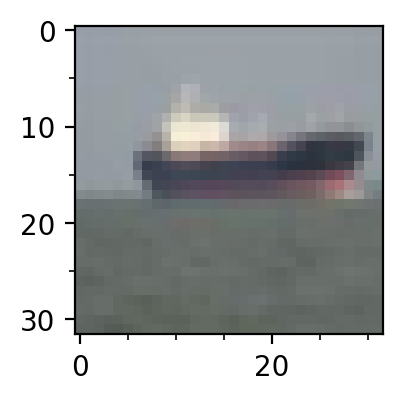

In [7]:
plt.xticks(list(range(0, 40, 5)), minor=True); plt.yticks(list(range(0, 40, 5)), minor=True)
plt.imshow(img);

In [8]:
dir(transforms) # list all the functions in the transforms module

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

In [9]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape     #C x H x W

torch.Size([3, 32, 32])

In [10]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                    transform=to_tensor)

In [11]:
img_t.min(), img_t.max()    #ToTensor() converts the image to a tensor and scales the values to [0, 1]

(tensor(0.1647, device='cpu'), tensor(0.9765, device='cpu'))

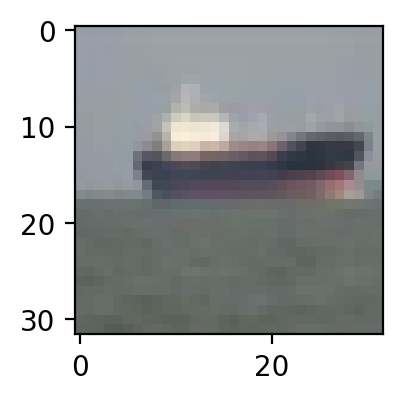

In [12]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [13]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10],
                    dim=3 #stacking along the 4th dimension
                    ) 
imgs.shape

torch.Size([3, 32, 32, 50000])

That's how we stack all of the dataset together in a single tensor cached in memory. This is doable in this case because of the small size of the dataset. For larger datasets, we will need to load and preprocess the data on the fly.

In [14]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465], device='cpu')

the method `.view(3, -1)` returns a view of the same data in the shape 3 (which is the color channels) and the remaining dimension is inferred from the data (aka. the rest of the dimensions are flattened into one dimension). This means that we now calculate the mean for all pixels in the whole dataset, for each color channel.

In [15]:
imgs.view(3, -1).std(dim=1) #same as above but with std

tensor([0.2470, 0.2435, 0.2616], device='cpu')

In [16]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
#note that these parameters are given beforehand for popular datasets

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

Here we inistantiate the normalizer using the parameters we just found. We then use the normalizer to transform the data. We can see that the mean is now 0 and the standard deviation is 1.

In [17]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                    (0.2470, 0.2435, 0.2616))]))

In [18]:
transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                    (0.2470, 0.2435, 0.2616))]),)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


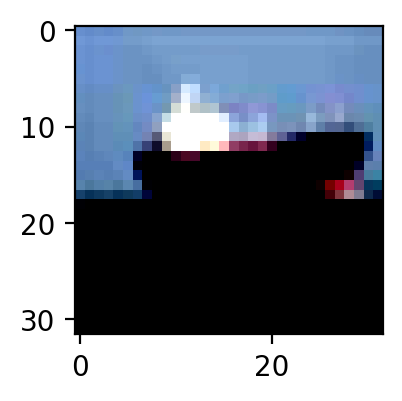

In [19]:
img_t, _ = transformed_cifar10[69]
plt.imshow(img_t.permute(1, 2, 0))
plt.show(); # the semicolon suppresses the output
            # note that plt.show() is not necessary in Jupyter notebooks for inline backend

In [20]:
transformed_cifar10[1]

(tensor([[[ 0.4551,  0.0106, -0.3228,  ..., -0.5451, -0.6086, -0.7356],
          [ 0.2329,  0.3123, -0.0053,  ..., -0.4657, -0.7674, -0.8626],
          [ 0.2329,  0.2170, -0.1640,  ..., -0.7356, -0.9103, -0.9261],
          ...,
          [ 0.7886,  0.4869,  0.4551,  ..., -1.3231, -1.0214, -0.5133],
          [ 0.6298,  0.4869,  0.5345,  ..., -0.3546, -0.0370,  0.0900],
          [ 0.5980,  0.5187,  0.5980,  ...,  0.2805,  0.2805,  0.2805]],
 
         [[ 0.8699,  0.2257, -0.3058,  ..., -0.4507, -0.5312, -0.6762],
          [ 0.5961,  0.4834,  0.0324,  ..., -0.3863, -0.6923, -0.8050],
          [ 0.5156,  0.3706, -0.1286,  ..., -0.6601, -0.8533, -0.8695],
          ...,
          [ 0.7088,  0.4995,  0.5961,  ..., -1.4331, -1.1271, -0.6440],
          [ 0.4995,  0.4673,  0.6122,  ..., -0.4829, -0.1447, -0.0320],
          [ 0.4028,  0.4028,  0.5317,  ...,  0.1613,  0.1774,  0.1613]],
 
         [[ 1.0953,  0.3308, -0.2838,  ..., -0.6436, -0.6436, -0.6586],
          [ 0.8255,  0.6006,

Look a bit cursed, but it's OK that's just for us, that's how the machine prefers.

In [21]:
class_names = ['airplane', 'bird']
cifar2d = []
cifar2l = []
for i, j in transformed_cifar10:
    if j in [0, 2]:
        cifar2d.append(i)
        cifar2l.append(0 if j == 0 else 1)

In [22]:
cifar2d_val = []
cifar2l_val = []
for i, j in transformed_cifar10:
    if j in [0, 2]:
        cifar2d_val.append(i)
        cifar2l_val.append(0 if j == 0 else 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


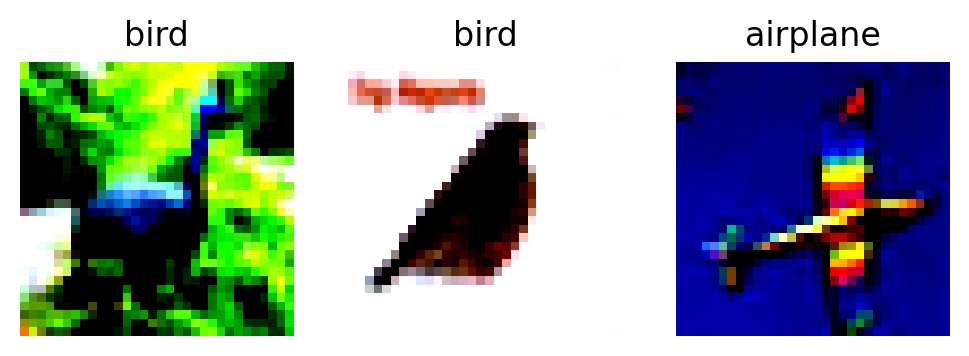

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(6, 2))
for i in range(3):
    ax[i].imshow(cifar2d[i*19].permute(1, 2, 0))
    ax[i].axis("off")
    ax[i].title.set_text(class_names[cifar2l[i*19]])

In [24]:
cifar2d_t = torch.stack(cifar2d).cuda()
cifar2l_t = torch.Tensor(cifar2l).cuda()
cifar2d_val_t = torch.stack(cifar2d_val).cuda()
cifar2l_val_t = torch.Tensor(cifar2l_val).cuda()

In [25]:
cifar2l_t.device

device(type='cuda', index=0)

In [26]:
n_out = 2
model = nn.Sequential(nn.Linear(3*32*32, 512),
                        nn.Tanh(),
                        nn.Linear(512, n_out),
                        nn.Softmax(dim=1)   # dim=1: sum of each row = 1
                                            # the softmax layer ensures that the output
                                            # is a valid probability distribution
                        )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


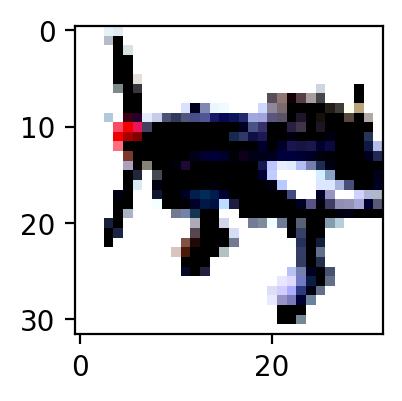

In [27]:
img = cifar2d[11]
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [28]:
img_batch = img.view(-1).unsqueeze(0).cuda()

In [29]:
model.cuda()
out = model(img_batch)
out

tensor([[0.3579, 0.6421]], grad_fn=<SoftmaxBackward0>)

In [30]:
_, index = torch.max(out, dim=1)    #so this is basically argmax
class_names[index.item()]

'bird'

Well, luck isn't on our side this time! The model isn't fitted yet, so it's not surprising that it's not predicting anything. Let's train it first.

In [41]:
model = nn.Sequential(nn.Linear(3*32*32, 512),
                        nn.Tanh(),
                        nn.Linear(512, n_out),
                        nn.LogSoftmax(dim=1)   #This is to make the calculation numerically stable 
                        )

In [45]:
loss = nn.NLLLoss()
img, label = cifar2d_t[0], cifar2l_t[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]).byte()) #note the conversion to byte tensor,
                                        # this helped in fixing the error of nll_loss with float input
                                        # note as well that all tensors should be on the same device             

tensor(0.0026, grad_fn=<NllLossBackward0>)

In [46]:
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:

loss_fn = nn.NLLLoss()
n_epochs = 100
for epoch in range(n_epochs):
    for i in range(len(cifar2l)):
        img, label = cifar2d_t[i] ,cifar2l_t[i]
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]).byte())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss < best_loss:
            best_loss = loss
            best_params = model.state_dict()
    

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

In each epoch, the model is trained on the CIFAR-2 dataset (`cifar2d_t` and `cifar2l_t`) using mini-batch stochastic gradient descent. The `img` and `label` variables represent a mini-batch of images and labels, respectively. The `img.view(-1).unsqueeze(0)` function call reshapes the image tensor into a 1D tensor and adds a new dimension to represent the batch size. The model is then used to predict the label for the current image (`out`), and the NLL loss function is used to compute the difference between the predicted and true labels (`loss`). The optimizer is then used to update the model parameters based on the gradients of the loss function with respect to the model parameters.

After each epoch, the current epoch number and loss value are printed to the console using the `print()` function. 

Note that the `torch.tensor([label]).byte()` call converts the label tensor to a byte tensor. This is because the `nn.NLLLoss()` function expects the label tensor to be a byte tensor with values in the range `[0, num_classes-1]`. If the label tensor is not a byte tensor, you may encounter a `RuntimeError` with a message similar to "llm is not implemented for float", that's what I got on `cuda`.

In [55]:
class_names[model(img_batch).argmax(dim=1)]

'airplane'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


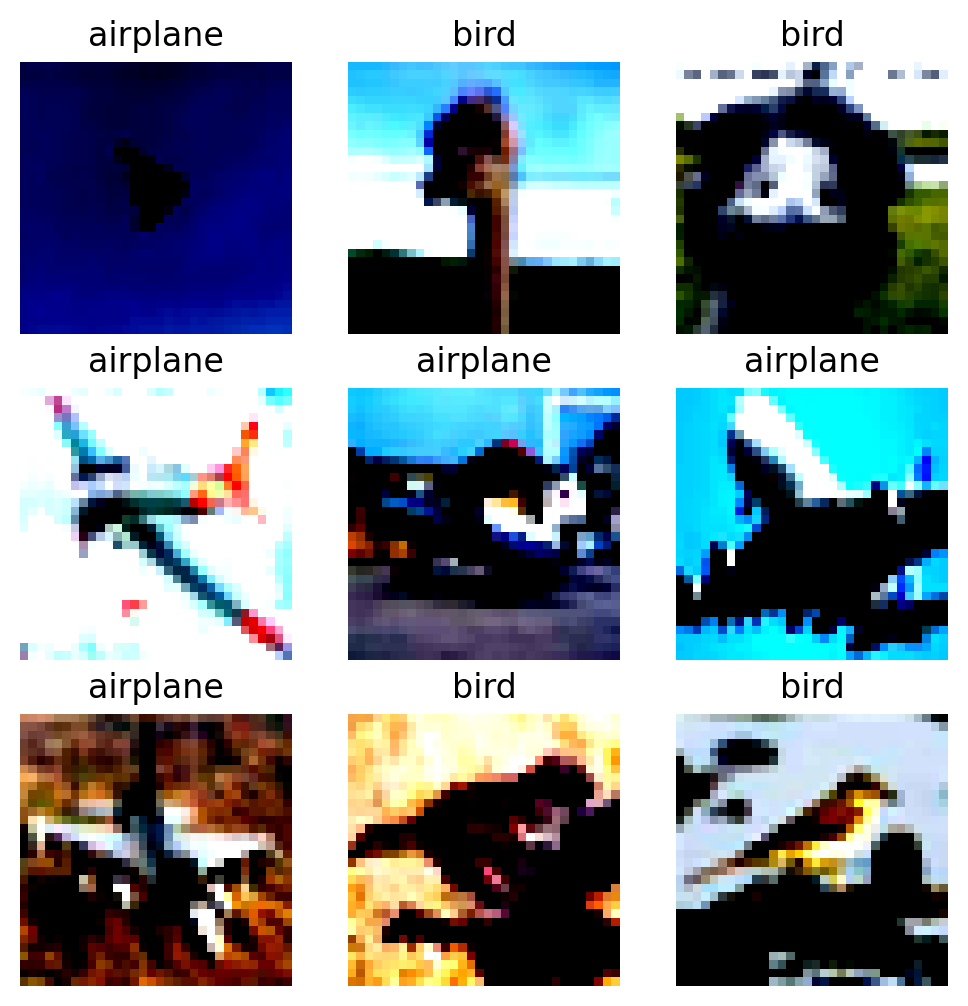

In [56]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        x = np.random.randint(0, 5000)
        ax[j, i].imshow((cifar2d[x].permute(1, 2, 0)));
        ax[j, i].axis("off")
        ax[j, i].title.set_text(class_names[model(cifar2d_t[x].view(-1).unsqueeze(0)).argmax(dim=1)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


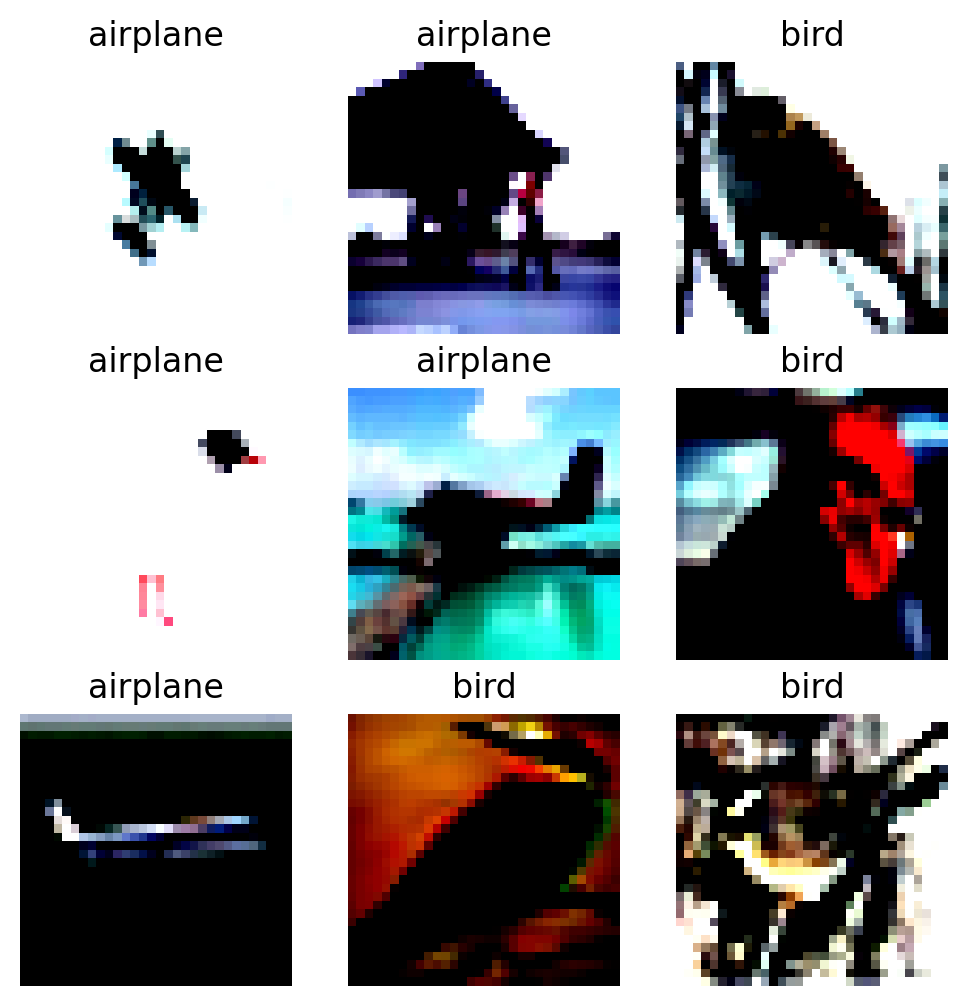

In [57]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        x = np.random.randint(0, 5000)
        ax[j, i].imshow((cifar2d_val[x].permute(1, 2, 0)));
        ax[j, i].axis("off")
        ax[j, i].title.set_text(class_names[model(cifar2d_val_t[x].view(-1).unsqueeze(0)).argmax(dim=1)])

In [74]:
#accuracy
def correct(out, labels):
    _,pred = torch.max(out, dim=1)
    return pred == labels

correct(model(cifar2d_t.view(len(cifar2l), -1)), cifar2l_t).cpu().numpy().mean(), correct(model(cifar2d_val_t.view(len(cifar2l_val), -1)), cifar2l_val_t).cpu().numpy().mean()


(0.9928, 0.9928)

## 7.3 Conclusion
In this chapter, we learned how to solve a simple classification problem using PyTorch. We started with a dataset and built a model, which we trained by minimizing an appropriate loss in a training loop. These skills and tools are essential for building and training neural networks using PyTorch, and they will be useful throughout your journey with the framework.

However, we discovered a limitation of our approach when dealing with 2D image data. Our model treated images as 1D data and did not take into account the translation invariance of the problem. In the next chapter, we will learn how to exploit the 2D nature of image data to get much better results.

Despite this limitation, we can still use what we have learned to process other types of data that do not have translation invariance, such as tabular or time-series data. We could also use it on appropriately represented text data, although more advanced models may be needed for better performance. It is worth noting that the same caveat about translation invariance also applies to purely 1D data, such as audio data.

## 7.4 Excersises
1. To implement random cropping of the data using torchvision, you can use the RandomCrop transform. Here are the answers to the questions:
    * $a$ - The resulting images from random cropping will be different from the uncropped originals because they will be a random subset of the original image. This can help to increase the diversity of the training data and improve the model's ability to generalize to new images.

    * $b$ - When you request the same image a second time, a different random crop will be selected. This can help to further increase the diversity of the training data.

    * $c$ - Training using randomly cropped images can help to improve the performance of the model by increasing the diversity of the training data. This can help to reduce overfitting and improve the model's ability to generalize to new images.

    2. Switching to a different loss function, such as mean squared error (MSE), can change the training behavior of the model. MSE places more emphasis on larger errors, so the model may prioritize reducing these errors over smaller ones. This can lead to a different trade-off between bias and variance, which can affect the model's performance.

    3. It is possible to reduce the capacity of the network to reduce overfitting. This can be done by reducing the number of layers or the number of neurons in each layer. When doing so, the model's performance on the validation set may decrease initially, but it should eventually stabilize at a lower level of performance. The key is to find the right balance between model complexity and performance on the validation set.

## 7.5 Summary
In summary, this chapter covered several key concepts and techniques related to computer vision and deep learning using PyTorch. We discussed the availability of annotated image datasets and how to load and sample them using DataLoaders. We also learned about the softmax function and cross entropy loss, which are commonly used for classification tasks.

We noted that treating images as vectors of pixel values can make it harder to take advantage of the spatial relationships in the data, and introduced the idea of using convolutional neural networks (CNNs) to exploit these relationships. We also learned about the nn.Sequential function, which provides a simple way to create neural networks composed of multiple layers in PyTorch.

Overall, this chapter provided a foundation for understanding the basics of computer vision and deep learning and how to implement them using PyTorch. These concepts and techniques will be important for building more advanced computer vision models in the future.